## Protein equilibrium during yeast growth
<br> This notebook includes a computational example of the protein synthesis-dilution equilibrium in *Saccharomyces cerevisiae*. This model was motivated by an experimental observation (PMID: 28680098). In that publication by Papagiannakis A. *et al.*, with title "Quantitative characterization of the auxin-inducible degron (AID): a guide for dynamic protein depletion in single yeast cells", I observed that after targeted protein depletion it takes multiple generations for the original protein concentration to be reconstituted. This was attributed to a constant, on average, protein build-up and a constant, on average, protein dilution factor from birth to division. This causes the protein concentration to increase in the yeast cells, until the protein synthesis matches its dilution, for a new equilibrium. Below, I am presenting a mathematical solution of this phenomenon with and without Gaussian noise. </br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def add_protein(start, add):
    return start+add

def dilute_protein(end, dil):
    return end - end*dil

def cycle_protein(birth, add, dil):
    division = add_protein(birth, add)
    next_birth = dilute_protein(division, dil)
    return division, next_birth


In [3]:
def simulate_model_without_noise(birth=0, added=100, dilution=2, generations=10):

    time_list = []
    conc_list = []

    for i in range(generations):
        time_list.append(i)
        conc_list.append(birth)
        division, next_birth = cycle_protein(birth, added, dilution)
        time_list.append(i+1)
        conc_list.append(division)
        birth = next_birth
    
    return time_list, conc_list


def simulate_model_with_noise(birth=0, mean_added=100, added_covariance=0.1, 
                              mean_dilution=0.3, dilution_covariance=0.1, generations=10, rseed=10):
    
    np.random.seed(rseed)
    added_dist = np.random.normal(loc=mean_added, scale=added_covariance*mean_added, size = generations)
    dilution_dist = np.random.normal(loc=mean_dilution, scale=dilution_covariance*mean_dilution, size = generations)
    
    time_list = []
    conc_list = []

    for i in range(generations):
        time_list.append(i)
        conc_list.append(birth)
        division, next_birth = cycle_protein(birth, added_dist[i], dilution_dist[i])
        time_list.append(i+1)
        conc_list.append(division)
        birth = next_birth
    
    return time_list, conc_list


def calculate_peaks_and_drops(conc_list):
    conc_array = np.array(conc_list)
    peaks = conc_array[1::2][0:-1]
    troughs = conc_array[2::2]
    diluted_array = peaks-troughs
    return peaks, diluted_array


def calculate_slope(peaks, diluted_array):
    return np.polyfit(peaks, diluted_array, 1)[0] 


def plot_model_data(time_list, conc_list):
    
    peaks, diluted_array = calculate_peaks_and_drops(conc_list)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    ax1.plot(time_list, conc_list, color='black')
    ax1.set_xlabel('Generations', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Protein concentration', fontsize=14, fontweight='bold')
    
    ax2.plot(peaks, diluted_array, 'o', color='k')
    ax2.set_xlabel('Max protein concentration per cycle (peak)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Protein dilution (drop)', fontsize=14, fontweight='bold')
    slope = calculate_slope(peaks, diluted_array)
    ax2.text(120,60,f"slope = {slope:.2f} ", fontsize=12)
    plt.show()
    

### Simulation without noise
1. The protein is completely depleted at the beginning of the simulation (birth=0)
2. The yeast cell adds 100 concentration units per cell division cycle
3. The yeast cell looses 30% of its protein due to dilution late in the cell division cycle

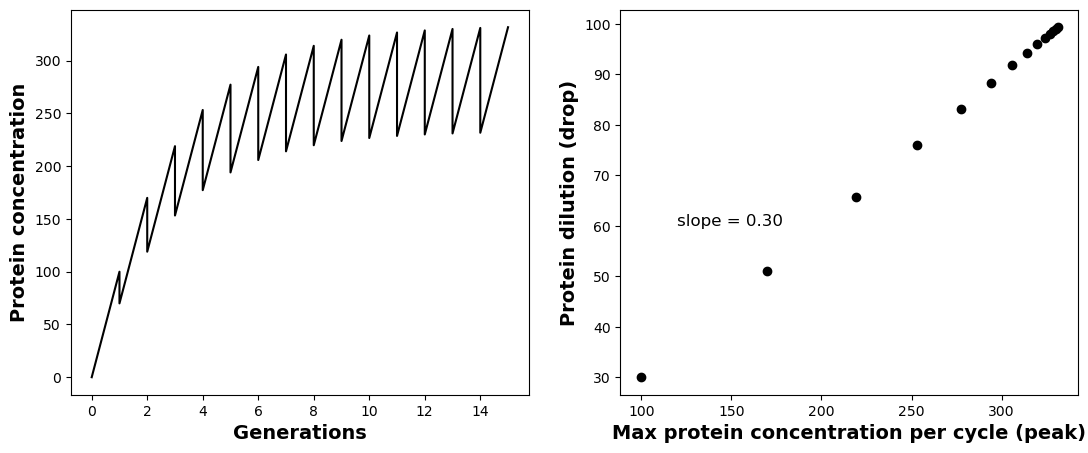

In [4]:
time_list, conc_list = simulate_model_without_noise(birth=0, added=100, dilution=0.3, generations=15)
plot_model_data(time_list, conc_list)

## Simulation with Gaussian noise added
1. The protein is completely depleted at the beginning of the simulation (birth=0)
2. The yeast cell adds 100 concentration units per cell division cycle on average  with a covariance of 15%
3. The yeast cell looses 30% of its protein due to dilution late in the cell division cycle on average witha covariance of 15%

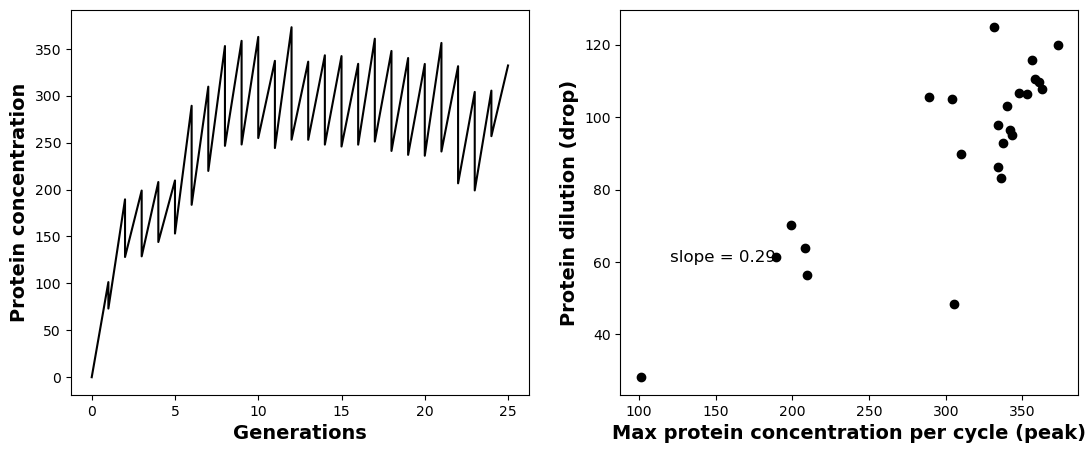

In [11]:

time_list, conc_list = simulate_model_with_noise(birth=0, mean_added=100, added_covariance=0.15, 
                              mean_dilution=0.3, dilution_covariance=0.15, generations=25, rseed=8)
plot_model_data(time_list, conc_list)

In [12]:
slope_list = []

for i in range(5000):
    time_list, conc_list = simulate_model_with_noise(birth=0, mean_added=100, added_covariance=0.15, 
                              mean_dilution=0.3, dilution_covariance=0.15, generations=10, rseed=i+10)
    
    peaks, diluted_array = calculate_peaks_and_drops(conc_list)
    slope_list.append(calculate_slope(peaks, diluted_array))

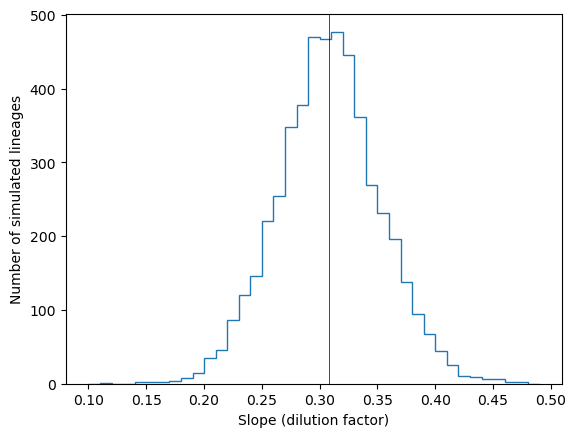

In [17]:
plt.hist(slope_list, bins=np.arange(0.1,0.5,0.01), histtype='step')
plt.axvline(np.mean(slope_list), color='black', linewidth=0.5)
plt.xlabel('Slope (dilution factor)')
plt.ylabel('Number of simulated lineages')
plt.show()